In [1]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Overview

This notebook demonstrates a retrieval augemented generation (RAG) approach to product attribute generation.

It assumes the the product category is already known. For detecting product category see this notebook

It consists of the following steps, each of which is expanded upon in the respective sections below:

1. Retrieve nearest neighbors

2. Extract descriptions and attributes from neighbors

3. Construct LLM Prompt

4. Generate Attributes

5. Evaluation

6. Anomaly Detection


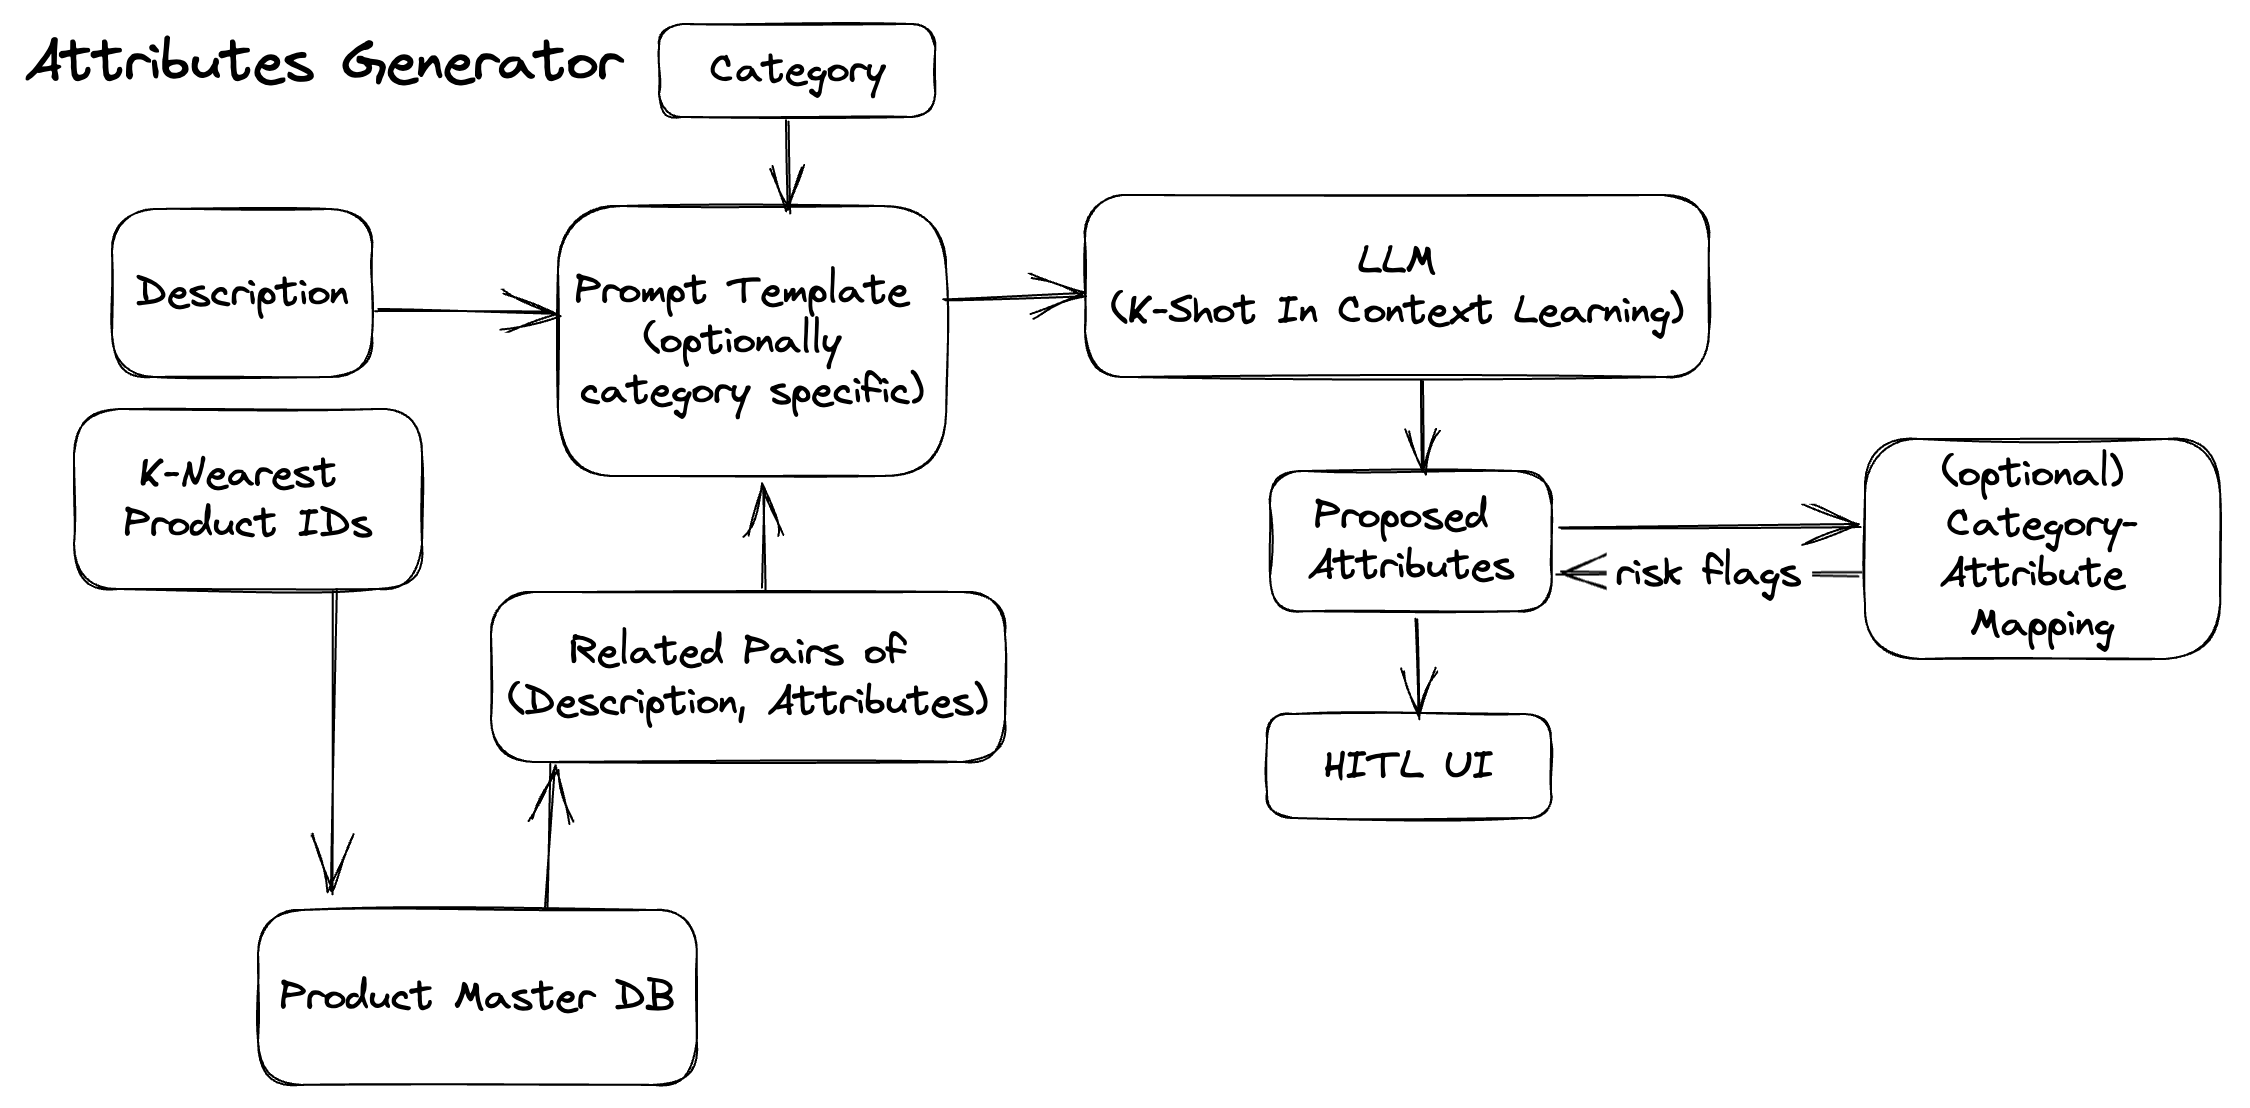

# Setup

### Install Dependencies (If Needed)

The list `packages` contains tuples of package import names and install names. If the import name is not found then the install name is used to install quitely for the current user.

In [ ]:
# tuples of (import name, install name)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform'),
    ('google.cloud.bigquery', 'google-cloud-bigquery[pandas]'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U --user

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [3]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Authenticate

If you are using Colab, you will need to authenticate yourself first. The next cell will check if you are currently using Colab, and will start the authentication process.

If you are using Vertex AI Workbench, you will not require additional authentication.

In [4]:
import sys

if 'google.colab' in sys.modules:
  from google.colab import auth as google_auth
  google_auth.authenticate_user()

### Imports

In [27]:
# Standard Library
import sys  
sys.path.insert(0, '../backend/')

# PyPi
from google.cloud import aiplatform
from google.cloud import bigquery
from tqdm import tqdm # allows progress bar
tqdm.pandas()

# Local Project Code
import embeddings

### Config

Update the below variables to point the Vector DB and BigQuery table you created in the previous notebooks

In [2]:
# GCP
PROJECT = 'solutions-2023-mar-107'
LOCATION = 'us-central1'

# Vertex Vector Store
ENDPOINT_ID = '1641918305943945216'
DEPLOYED_INDEX = 'flipkart_streaming_filteri_1702030773989'
NUM_NEIGHBORS = 7 # Fetches NUM_NEIGBHORS for both text and image embeddings

# BigQuery
MASTER_PRODUCT_TABLE = 'solutions-2023-mar-107.flipkart.18K_no_duplicate'
TEST_SET_TABLE = 'solutions-2023-mar-107.flipkart.flipkart_golden_test'
ATTRIBUTE_TABLE = 'solutions-2023-mar-107.flipkart.attributes'

### Initiate Libraries

In [ ]:
import vertexai
from vertexai.language_models import TextGenerationModel
vertexai.init(project=PROJECT, location=LOCATION)
parameters = {
    "max_output_tokens": 256,
    "temperature": 0.0,
}

# 0. Test Inputs

End user provides an image and a short product description. We also assume we know the category.

In [4]:
DESCRIPTION = "Key Features of Vishudh Printed Women's Straight Kurta BLACK, GREY Straight,Specifications of Vishudh Printed Women's Straight Kurta Kurta Details Sleeve Sleeveless Number of Contents in Sales Package Pack of 1 Fabric 100% POLYESTER Type Straight Neck ROUND NECK General Details Pattern Printed Occasion Festive Ideal For Women's In the Box Kurta Additional Details Style Code VNKU004374 BLACK::GREY Fabric Care Gentle Machine Wash in Lukewarm Water, Do Not Bleach"
IMAGE_URL = 'gs://genai-product-catalog/flipkart_20k_oct26/3ecb859759e5311cbab6850e98879522_0.jpg'

# 1. Similar Product NN Search

The system will use multimodal embeddings to create a semantic vector representations of the product description and product image. We leverage the [Vertex AI Embedding API](https://cloud.google.com/vertex-ai/docs/generative-ai/embeddings/get-image-embeddings) for this.

It is important to note that text and image data is not fused into a single embedding. The service provides text-only and image-only embeddings, but they share an embedding space. In other words the text 'cat' and a picture of a cat should return similar embeddings.

### Embed

In [5]:
emb = embeddings.embed(
    text=DESCRIPTION,
    image=IMAGE_URL,
    project=PROJECT)

print(emb.text_embedding[:5])
print(emb.image_embedding[:5])

[-0.0165299643, -0.0692435056, 0.0147972815, 0.0349165909, 0.00536282267]
[-0.00627783127, 0.0557950921, -0.0300529636, 0.0268287677, 0.0392316207]


### Fetch K Nearest Neighbors

This notebooks assumes a Vertex Vector Search Index with product image and text embeddings is already deployed. For instructions on that see 2_create_vector_db.ipynb.

Note at inference time we may be provided an image, a description, or both. This will result in 1-2 embeddings, and we will return the nearest neighbors for each. Because images and text share an embedding space, images can be used to find related text and and text and be used to find related images.

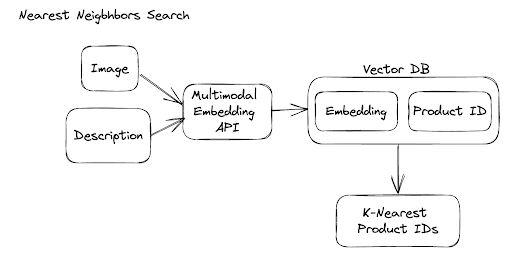



In [6]:
my_index_endpoint = aiplatform.MatchingEngineIndexEndpoint(
    index_endpoint_name=ENDPOINT_ID,
    project=PROJECT,
    location=LOCATION
)

In [7]:
response = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=NUM_NEIGHBORS,
)

response

[[MatchNeighbor(id='3ecb859759e5311cbab6850e98879522_T', distance=0.0),
  MatchNeighbor(id='0305111c779fe663bd94122bef0f0002_T', distance=0.18872332572937012),
  MatchNeighbor(id='ba8163913f5e384d17a8202b1f8b91b3_T', distance=0.2593117952346802),
  MatchNeighbor(id='6ef0a5eb033cd610d455be7102da5685_T', distance=0.34411925077438354),
  MatchNeighbor(id='ee383a337af67ae8ad4f42714d67ddaf_T', distance=0.34411925077438354),
  MatchNeighbor(id='37e703b75b9a2c465aa78f8264544afd_T', distance=0.34629255533218384),
  MatchNeighbor(id='c9c27aa5dc7df49e82e55e8abb6b4020_T', distance=0.3481863737106323)],
 [MatchNeighbor(id='3ecb859759e5311cbab6850e98879522_I', distance=-1.1920928955078125e-07),
  MatchNeighbor(id='06ad8323cf9105f1aaae6515cf08a7d6_I', distance=0.03433758020401001),
  MatchNeighbor(id='c9c27aa5dc7df49e82e55e8abb6b4020_I', distance=0.042382776737213135),
  MatchNeighbor(id='169902631b89202f0e2079e9cc09b3c7_I', distance=0.047686874866485596),
  MatchNeighbor(id='5614ccefd0ab9bee5cd28bf

# 2. Evaluation Data and Functions

Now that we've demonstrated vector based retrieval on a single example, let's evaluate the approach using our golden test set containing ~100 examples.

The items in the test set are excluded from the vector database to simulate these being new/unkown items.

In [10]:
from google.cloud import bigquery
bq_client = bigquery.Client(PROJECT)

query = f"""
  SELECT
    id,
    description,
    image_uri,
    c0_name,
    c1_name,
    c2_name,
    c3_name,
    train_val_count,
    attributes
  FROM
    `{TEST_SET_TABLE}`
  JOIN `{ATTRIBUTE_TABLE}`
  ON
    `{TEST_SET_TABLE}`.id = `{ATTRIBUTE_TABLE}`.uniq_id
  WHERE
    manual_validation = 1 AND
    train_val_count >= 1

"""
df = bq_client.query(query).to_dataframe()

/home/reddyv/.local/lib/python3.9/site-packages/google/cloud/bigquery/_pandas_helpers.py:195: UserWarning: Unable to determine type for field 'attributes'.
  warnings.warn("Unable to determine type for field '{}'.".format(bq_field.name))


In [11]:
df.head()

id  \
0  5935ed077915347dc695744df68c565c   
1  e9eb010ed8313f65f0e049fc3fcffe87   
2  6325b6870c54cd47be6ebfbffa620ec7   
3  a8f99924be2c3dc4c6c4d0208f55cc66   
4  384ad3e62d1471adafe54e85543e85df   

                                         description  \
0  Specifications of KAJCI Embroidered Women's Wa...   
1  Rapter BNC-179 BNC Wire Connector (Silver, Pac...   
2  Key Features of Jaipur Print Cotton Floral Kin...   
3  Stylistry Maxis Shde6603brwoboot3104 Boots - B...   
4  Foot Candy Women Heels Price: Rs. 899 With an ...   

                                           image_uri           c0_name  \
0  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
1  gs://genai-product-catalog/flipkart_20k_oct26/...  Tools & Hardware   
2  gs://genai-product-catalog/flipkart_20k_oct26/...   Home Furnishing   
3  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
4  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   

            c1_name                 c2_name                 c3_name  \
0  Women's Clothing             Formal Wear              Waistcoats   
1             Tools  Hardware & Electricals                Hardware   
2         Bed Linen               Bedsheets  Jaipur Print Bedsheets   
3  Women's Footwear            Casual Shoes                   Boots   
4  Women's Footwear                   Heels                    None   

   train_val_count                                         attributes  
0                1  {"Fabric":"Art Silk","Ideal For":"Women's","Pa...  
1                1  {"Brand":"Rapter","Color":"Silver","Corrosion ...  
2                1  {"Brand":"Jaipur Print","Color":"White","Fabri...  
3                1  {"Care Instructions":"Do Not Bleach","Color":"...  
4                1  {"Color":"Silver","Heel Height":"3 inch","Idea...

## Get Predictions

Let's combine the embed, retrieval, and attribute generation steps into a single function. At this point we're just using a greedy approach where we take the attributes of the nearest neighbors in embedding space. In the next section we will introduce an LLM to improve results.

In [17]:
import ast

def parse_attributes(string):
  attributes = ast.literal_eval(string)
  reformat_attributes = []
  for k,v in attributes.items():
    v = v.replace('"','')
    reformat_attributes.append(f'{k}: {v}')
  return reformat_attributes

def get_nearestn_attributes_and_descriptions(desc: str, image_uri: str, num_neighbors = 3):
  description = desc[:900]

  emb = embeddings.embed(description,image_uri,project=PROJECT)
  #print([emb.text_embedding,emb.image_embedding])
  neighbors = my_index_endpoint.find_neighbors(
    deployed_index_id=DEPLOYED_INDEX,
    queries=[emb.text_embedding,emb.image_embedding],
    num_neighbors=num_neighbors,
  )
  ids = [r.id[:-2] for neighbor in neighbors for r in neighbor]
  query = f"""
    SELECT
      a.uniq_id as id,
      c0_name,
      c1_name,
      c2_name,
      c3_name,
      description,
      attributes
    FROM
      `{MASTER_PRODUCT_TABLE}` as a
    JOIN `{ATTRIBUTE_TABLE}` as b
    ON
     a.uniq_id = b.uniq_id
    WHERE
      a.uniq_id IN {str(ids).replace('[','(').replace(']',')')}
    """
  query_job = bq_client.query(query)
  rows = query_job.result()
  items = []
  for row in rows:
    parsed_attributes = parse_attributes(row['attributes'])
    items.append({"attributes":parsed_attributes,"description":row['description']})

  return items

In [15]:
# run one item
candidates = get_nearestn_attributes_and_descriptions(DESCRIPTION, IMAGE_URL)
print(candidates)

[{'attributes': ['Fabric: Cotton', "Ideal For: Women's", 'Neck: Collar', 'Number of Contents in Sales Package: Pack of 1', 'Occasion: Casual', 'Pattern: Printed', 'Sleeve: 3/4 Sleeve', 'Style Code: GC26BLACK', 'Type: Straight'], 'description': "Key Features of Gulmohar Jaipur Printed Women's Straight Kurta Black Straight,Specifications of Gulmohar Jaipur Printed Women's Straight Kurta Kurta Details Sleeve 3/4 Sleeve Number of Contents in Sales Package Pack of 1 Fabric Cotton Type Straight Neck Collar General Details Pattern Printed Occasion Casual Ideal For Women's In the Box KURTA Additional Details Style Code GC26BLACK"}, {'attributes': ['Fabric: 100% POLYESTER', "Ideal For: Women's", 'Neck: ROUND NECK', 'Number of Contents in Sales Package: Pack of 1', 'Occasion: Festive', 'Pattern: Printed', 'Sleeve: Sleeveless', 'Style Code: VNKU004374 BLACK::GREY', 'Type: Straight'], 'description': "Key Features of Vishudh Printed Women's Straight Kurta BLACK, GREY Straight,Specifications of Vish

## Eval Functions

This evaluation function two matching functions:


*   Exact Matching
*   Semantic Matching


Exact matching will only count an attribute as correct if it is 100% matching while semantic matching will only match if the generated attribute is semantically similar to the ground truth attribute.

Semantic similarity works by taking the dot product of two embeddings. Here, you will get a value between 0 and 1. The next step is to define a similarity threshold that helps to mark it as correct vs. incorrect. This threshold can be set anywhere from 0 to 1 where 0 will match everything as correct and 0.999 will check for exact matching.

Take this example:

ground_truth_list = ["The", "quick", "brown", "fox", "jumps", "over", "the", "lazy", "dog"]

predicted_list = ["The", "fast", "maroon", "fox","hops", "over", "the", "lazy", "canine"]

If we set a similarity threshold of 0.7 you will get a matching F1 score of 1.0 which is a perfect score. Now, when we set the threshold is 0.99 then the F1 will be 0.55.

In [18]:
from vertexai.preview.language_models import TextEmbeddingModel
import numpy as np

emb_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")

def str_to_ls(x):
  return x.strip(" ").replace("[", "").replace("]", "").replace("  ", " ").replace("' '", ",").replace("'","").replace(", ",",").replace("\"","").split("|")

# this one is quicker since it does not have to call the text emb api
def exact_match(text_one, text_two):

  if text_one == text_two:
    return 1
  else:
    return 0

# this one is slow since it is making a call to the embedding api
def embed_match(text_one, text_two, threshold):

  if text_one == "" or text_two == "":
    return 0

  if text_one == text_two:
    return 1

  try:
    embedding_response = emb_model.get_embeddings([text_one, text_two])
  except Exception as e:
    print(e)
    raise

  embeddings = [embedding.values for embedding in embedding_response]

  similarity = np.dot(embeddings[0], embeddings[1])

  if similarity >= threshold:
    return 1
  else:
    return 0


def get_match_precision_and_recall(row, ground_truth_list, predicted_list,
                                   similarity_threshold, match_type):
  """
  Calculates the match precision and recall for two lists of words, ignoring order.

  Args:
    ground_truth_list: A list of ground truth words.
    predicted_list: A list of predicted words.
    similarity_threshold: only applies for semantic match
    match_type: takes two values "exact" and "semantic"

  Returns:
    A tuple of (precision, recall).
  """
  print(f'row: {row}')
  print(f'description: {row.description}')
  print(f'ground_truth_list: {ground_truth_list}')
  print(f'predicted_list: {predicted_list}')
  print(f'similarity_threshold: {similarity_threshold}')
  print(f'match_type: {match_type}')

  if len(ground_truth_list) == 0 or len(predicted_list) == 0:
    return(0,0,0)

  if match_type not in ["exact", "semantic"]:
    raise ValueError("match_type must be either 'exact' or 'semantic'")

  # Create a set of the ground truth words.
  ground_truth_set = set(ground_truth_list)
  predicted_set = set(predicted_list)

  # Calculate the number of correct predictions.
  num_match_predictions = 0
  for predicted_word in predicted_set:
    for gt_word in ground_truth_set:

      # get matching score between two words
      if match_type == "exact":
        matches = exact_match(predicted_word, gt_word)
      elif match_type == "semantic":
        matches = embed_match(predicted_word, gt_word,similarity_threshold)
      else:
        raise ValueError("match_type must be either 'exact' or 'semantic'")

      if matches:
        num_match_predictions += 1
        break # move on to the next word


  # Calculate f1 score.
  precision = num_match_predictions / len(predicted_set)
  recall = num_match_predictions / len(ground_truth_set)
  if precision + recall == 0:
    f1 = 0
  else:
    f1 = 2 * (precision * recall) / (precision + recall)

  return f1, precision, recall

# 5. Evaluate LLM Prompts on DataSet

Let's see if we can improve upon the greed approach by asking and LLM to select from the Top K candidates based on a relvance to user description

## Prompt

In [50]:
def generate_prompt(description: str, candidates: list[list[str]]) -> tuple[list[str], str]:

  examples = ""
  for candidate in candidates:
    examples += 'Description:\n' + candidate['description']+'\n'
    examples += 'Attributes: ' + '|'.join(candidate['attributes'])+'\n\n'

  query = f"""

Here are examples of Product Descriptions followed by Attributes:

{examples}

INSTRUCTIONS:
Generate attributes based on the description below.
Each attribute should be a key:value pair.
Do not write any values that contain "NA" on the list. Examples "Material: NA" or "Type: NA"
Use a pipe separator "|" to separate attributes.

Description: {description}
Attributes:
"""

  return query

In [51]:
# Test retrieval and prompt generation on a single item
item = df.loc[df['id'] == '894904e26516d491bf1c7711fe800e78'].iloc[0]
candidates = get_nearestn_attributes_and_descriptions(item.description,item.image_uri, NUM_NEIGHBORS)
prompt = generate_prompt(item.description, candidates)
print(prompt)



Here are examples of Product Descriptions followed by Attributes:

Description:
Marvel DW100243 Digital Watch - For Boys, Girls - Buy Marvel DW100243 Digital Watch - For Boys, Girls DW100243 Online at Rs.299 in India Only at Flipkart.com. Buckle Clasp, Multi-color Strap, Contemporary Dial - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Attributes: Clasp Type: Buckle|Dial Shape: Contemporary|Ideal For: Boys, Girls|Other Body Features: Mineral Glass Dial|Strap Color: Multi-colored|Strap Material: Plastic Strap|Style Code: DW100243|Type: Digital

Description:
Jack klein BlackLed Digital Watch - For Boys - Buy Jack klein BlackLed Digital Watch - For Boys BlackLed Online at Rs.150 in India Only at Flipkart.com. - Great Discounts, Only Genuine Products, 30 Day Replacement Guarantee, Free Shipping. Cash On Delivery!
Attributes: Alarm Clock: No|Altimeter: No|Barometer: No|Calendar: No|Chronograph: No|Compass: No|Date Display: No|Dial C

In [52]:
import re

def llm_generate(description: str, image_url: str, num_neighbors = NUM_NEIGHBORS) -> tuple[list[str], str]:
  """Return category and explanation"""

  candidates = get_nearestn_attributes_and_descriptions(description,image_url)

  prompt = generate_prompt(description, candidates)

  model = TextGenerationModel.from_pretrained("text-bison")
  response = model.predict(
      prompt,
      **parameters
  )
  res = response.text.splitlines()
  if not res:
    raise ValueError('ERROR: no LLM response returned. This seems to be an intermittent bug')
  #print(f'Query:\n{query}')
  #formatted_response = [re.sub(r"^\d+\.\s+", "", line.lstrip()).split('->') for line in res]
  #if len(formatted_response[0]) != len(candidates[0]):
  #  raise ValueError(f'ERROR: length of response - {formatted_res} and candidate - {candidates[0]} must match.')

  #unique_res = list(dict.fromkeys([tuple(l) for l in formatted_res]))
  #print(f'Formatted Response:\n {unique_res}')
  return res

def llm_generate_with_fallback(description: str, candidates: list[list[str]]) -> list[str]:
  """Wrapper around llm_rerank() to catch errors and return something sensible"""
  try:
    return llm_generate(description, candidates)[0]
  except ValueError as e:
    print(e)
    print('Falling back to greedy approach. Taking nearest neighbor in embedding space.')
    return candidates[0]

In [54]:
# Test single item
item = df.loc[df['id'] == '5935ed077915347dc695744df68c565c'].iloc[0]
print(item)
res = llm_generate_with_fallback(item.description, item.image_uri)
print("item attributes: " + item.attributes)
print("generated attributes: " + res)

id                                  5935ed077915347dc695744df68c565c
description        Specifications of KAJCI Embroidered Women's Wa...
image_uri          gs://genai-product-catalog/flipkart_20k_oct26/...
c0_name                                                     Clothing
c1_name                                             Women's Clothing
c2_name                                                  Formal Wear
c3_name                                                   Waistcoats
train_val_count                                                    1
attributes         {"Fabric":"Art Silk","Ideal For":"Women's","Pa...
Name: 0, dtype: object
item attributes: {"Fabric":"Art Silk","Ideal For":"Women's","Pattern":"Embroidered","Style Code":"LKOD112"}
generated attributes:  Fabric: Art Silk|Ideal For: Women's|Occasion: NA|Pattern: Embroidered|Style Code: LKOD112


### Generate Attributes for All Rows

In [55]:
df_test = df.head(200) # select number of rows to evaluate

In [56]:
%%time
#Run of Test Set, takes ~ 10 min
count = 0

df_test["generated_attributes"] = df_test.progress_apply(lambda x: llm_generate_with_fallback(x.description, x.image_uri), axis=1)
df_test.head();

100%|██████████| 173/173 [07:49<00:00,  2.71s/it]

CPU times: user 7.86 s, sys: 951 ms, total: 8.81 s
Wall time: 7min 49s



<timed exec>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Exact Match Evaluation

In [57]:
# test evaluation for one example
x = df_test.iloc[2]
get_match_precision_and_recall(x, parse_attributes(x["attributes"]),
                                          str_to_ls(x["generated_attributes"]),
                                          0.8, "exact"
                                        )

row: id                                       6325b6870c54cd47be6ebfbffa620ec7
description             Key Features of Jaipur Print Cotton Floral Kin...
image_uri               gs://genai-product-catalog/flipkart_20k_oct26/...
c0_name                                                   Home Furnishing
c1_name                                                         Bed Linen
c2_name                                                         Bedsheets
c3_name                                            Jaipur Print Bedsheets
train_val_count                                                         1
attributes              {"Brand":"Jaipur Print","Color":"White","Fabri...
generated_attributes     Brand: Jaipur Print|Character: NA|Color: Whit...
Name: 2, dtype: object
description: Key Features of Jaipur Print Cotton Floral King sized Double Bedsheet 100% cotton,Jaipur Print Cotton Floral King sized Double Bedsheet (1 bed sheet 2 pillow cover, White) Price: Rs. 998 This nice bed sheet made up of 1

(0.9302325581395349, 0.9090909090909091, 0.9523809523809523)

In [ ]:
# test for all data
df_test['prompt_one_exact_score'] = df_test.progress_apply(lambda x: get_match_precision_and_recall( x,
                                          parse_attributes(x["attributes"]),
                                          str_to_ls(x["generated_attributes"]),
                                          0.8, "exact"
                                        ), axis=1)


In [59]:
import pandas as pd

mean_scores = df_test["prompt_one_exact_score"].apply(pd.Series).mean()

print("Precision: " + str(mean_scores[1]))
print("Recall: " + str(mean_scores[2]))
print("F1: " + str(mean_scores[0]))

Precision: 0.6450202051081183
Recall: 0.6139370850969151
F1: 0.6219751373124824


In [60]:
# manually review some results
df_test.head(10)

id  \
0  5935ed077915347dc695744df68c565c   
1  e9eb010ed8313f65f0e049fc3fcffe87   
2  6325b6870c54cd47be6ebfbffa620ec7   
3  a8f99924be2c3dc4c6c4d0208f55cc66   
4  384ad3e62d1471adafe54e85543e85df   
5  db7c6c1297417d1b95eb80c4964a864e   
6  6966c2922f11086e7dcd81fbb582d5cf   
7  e8303b453cace6277914b79775e58e8c   
8  43a5ab7e3d9dcba5d55f84a5c2aa8f5c   
9  f96f3e426924fed9cf7c875df4cbf5de   

                                         description  \
0  Specifications of KAJCI Embroidered Women's Wa...   
1  Rapter BNC-179 BNC Wire Connector (Silver, Pac...   
2  Key Features of Jaipur Print Cotton Floral Kin...   
3  Stylistry Maxis Shde6603brwoboot3104 Boots - B...   
4  Foot Candy Women Heels Price: Rs. 899 With an ...   
5  Navaksha Necktie Men's Combo Price: Rs. 756 Na...   
6  FabAlley Casual Sleeveless Solid Women's Top -...   
7  Bellafoz Women Heels Price: Rs. 499 Bellafoz p...   
8  Karatcraft Citra Engagement Gold Diamond 18 K ...   
9  Key Features of AKUP i-love-dubstep Ceramic Mu...   

                                           image_uri           c0_name  \
0  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
1  gs://genai-product-catalog/flipkart_20k_oct26/...  Tools & Hardware   
2  gs://genai-product-catalog/flipkart_20k_oct26/...   Home Furnishing   
3  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
4  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
5  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
6  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
7  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
8  gs://genai-product-catalog/flipkart_20k_oct26/...         Jewellery   
9  gs://genai-product-catalog/flipkart_20k_oct26/...  Kitchen & Dining   

            c1_name                  c2_name  \
0  Women's Clothing              Formal Wear   
1             Tools   Hardware & Electricals   
2         Bed Linen                Bedsheets   
3  Women's Footwear             Casual Shoes   
4  Women's Footwear                    Heels   
5    Men's Clothing  Navaksha Men's Clothing   
6  Women's Clothing             Western Wear   
7  Women's Footwear                    Heels   
8             Rings                     None   
9       Coffee Mugs         AKUP Coffee Mugs   

                                    c3_name  train_val_count  \
0                                Waistcoats                1   
1                                  Hardware                1   
2                    Jaipur Print Bedsheets                1   
3                                     Boots                1   
4                                      None                1   
5                                      None                1   
6                     Shirts, Tops & Tunics                1   
7                                      None                1   
8                                      None                1   
9  AKUP i-love-dubstep Ceramic Mug (300 ml)                1   

                                          attributes  \
0  {"Fabric":"Art Silk","Ideal For":"Women's","Pa...   
1  {"Brand":"Rapter","Color":"Silver","Corrosion ...   
2  {"Brand":"Jaipur Print","Color":"White","Fabri...   
3  {"Care Instructions":"Do Not Bleach","Color":"...   
4  {"Color":"Silver","Heel Height":"3 inch","Idea...   
5  {"Ideal For":"Men's","Pattern":"Checkered","Pr...   
6  {"Fabric":"Poly Crepe","Ideal For":"Women's","...   
7  {"Closure":"Small Back Strap","Color":"Golden"...   
8  {"Base Material":"Gold","Brand":"Karatcraft","...   
9  {"Depth":"8 mm","Diameter":"8 mm","Freezer Saf...   

                                generated_attributes  \
0   Fabric: Art Silk|Ideal For: Women's|Occasion:...   
1   Brand: Rapter|Color: Silver|Corrosion Proof: ...   
2   Brand: Jaipur Print|Character: NA|Color: Whit...   
3   Attributes: Color: Brown|Heel Height: 1 inch|...   
4   Color: Black|Heel Height: 3 inch|Ide

### Semantic Match Evaluation

In [ ]:
# test for all data
# note that each example can take a few seconds (5-15s each). Be careful when running a large dataset
df_test['prompt_one_semantic_score'] = df_test.progress_apply(lambda x: get_match_precision_and_recall( x,
                                          parse_attributes(x["attributes"]),
                                          str_to_ls(x["generated_attributes"]),
                                          0.8, "semantic"
                                        ), axis=1)

In [62]:
import pandas as pd

mean_scores = df_test["prompt_one_semantic_score"].apply(pd.Series).mean()

print("Precision: " + str(mean_scores[1]))
print("Recall: " + str(mean_scores[2]))
print("F1: " + str(mean_scores[0]))

Precision: 0.8889615762624407
Recall: 0.8660878610394018
F1: 0.8632914689924285


In [63]:
# manually review some results
df_test.head(10)

id  \
0  5935ed077915347dc695744df68c565c   
1  e9eb010ed8313f65f0e049fc3fcffe87   
2  6325b6870c54cd47be6ebfbffa620ec7   
3  a8f99924be2c3dc4c6c4d0208f55cc66   
4  384ad3e62d1471adafe54e85543e85df   
5  db7c6c1297417d1b95eb80c4964a864e   
6  6966c2922f11086e7dcd81fbb582d5cf   
7  e8303b453cace6277914b79775e58e8c   
8  43a5ab7e3d9dcba5d55f84a5c2aa8f5c   
9  f96f3e426924fed9cf7c875df4cbf5de   

                                         description  \
0  Specifications of KAJCI Embroidered Women's Wa...   
1  Rapter BNC-179 BNC Wire Connector (Silver, Pac...   
2  Key Features of Jaipur Print Cotton Floral Kin...   
3  Stylistry Maxis Shde6603brwoboot3104 Boots - B...   
4  Foot Candy Women Heels Price: Rs. 899 With an ...   
5  Navaksha Necktie Men's Combo Price: Rs. 756 Na...   
6  FabAlley Casual Sleeveless Solid Women's Top -...   
7  Bellafoz Women Heels Price: Rs. 499 Bellafoz p...   
8  Karatcraft Citra Engagement Gold Diamond 18 K ...   
9  Key Features of AKUP i-love-dubstep Ceramic Mu...   

                                           image_uri           c0_name  \
0  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
1  gs://genai-product-catalog/flipkart_20k_oct26/...  Tools & Hardware   
2  gs://genai-product-catalog/flipkart_20k_oct26/...   Home Furnishing   
3  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
4  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
5  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
6  gs://genai-product-catalog/flipkart_20k_oct26/...          Clothing   
7  gs://genai-product-catalog/flipkart_20k_oct26/...          Footwear   
8  gs://genai-product-catalog/flipkart_20k_oct26/...         Jewellery   
9  gs://genai-product-catalog/flipkart_20k_oct26/...  Kitchen & Dining   

            c1_name                  c2_name  \
0  Women's Clothing              Formal Wear   
1             Tools   Hardware & Electricals   
2         Bed Linen                Bedsheets   
3  Women's Footwear             Casual Shoes   
4  Women's Footwear                    Heels   
5    Men's Clothing  Navaksha Men's Clothing   
6  Women's Clothing             Western Wear   
7  Women's Footwear                    Heels   
8             Rings                     None   
9       Coffee Mugs         AKUP Coffee Mugs   

                                    c3_name  train_val_count  \
0                                Waistcoats                1   
1                                  Hardware                1   
2                    Jaipur Print Bedsheets                1   
3                                     Boots                1   
4                                      None                1   
5                                      None                1   
6                     Shirts, Tops & Tunics                1   
7                                      None                1   
8                                      None                1   
9  AKUP i-love-dubstep Ceramic Mug (300 ml)                1   

                                          attributes  \
0  {"Fabric":"Art Silk","Ideal For":"Women's","Pa...   
1  {"Brand":"Rapter","Color":"Silver","Corrosion ...   
2  {"Brand":"Jaipur Print","Color":"White","Fabri...   
3  {"Care Instructions":"Do Not Bleach","Color":"...   
4  {"Color":"Silver","Heel Height":"3 inch","Idea...   
5  {"Ideal For":"Men's","Pattern":"Checkered","Pr...   
6  {"Fabric":"Poly Crepe","Ideal For":"Women's","...   
7  {"Closure":"Small Back Strap","Color":"Golden"...   
8  {"Base Material":"Gold","Brand":"Karatcraft","...   
9  {"Depth":"8 mm","Diameter":"8 mm","Freezer Saf...   

                                generated_attributes  \
0   Fabric: Art Silk|Ideal For: Women's|Occasion:...   
1   Brand: Rapter|Color: Silver|Corrosion Proof: ...   
2   Brand: Jaipur Print|Character: NA|Color: Whit...   
3   Attributes: Color: Brown|Heel Height: 1 inch|...   
4   Color: Black|Heel Height: 3 inch|Ide

# Summary of Results

**RAG with Few-Shot Prompting**

Summary of Method: Retrieve top 10 occuring attributes from 7 nearest neighbors, feed into LLM prompt

*Exact Matching*

Precision: 0.6522124912684425\
Recall: 0.6337891699988937\
F1: 0.6363465653158453

*Semantic Matching*

Precision: 0.8913030993766494\
Recall: 0.866743534535691\
F1: 0.8676342704970403


